# Stratified analysis of case-crossover or case-control data

In [1]:
#load packages
library(tidyverse)
library(survival)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************




## About the data  

The analysis below is ran on data from case-crossover study. Case-crossover design is similar to case-control design, but there are no control patients. Instead each patient at different time serves as his or her own control. See [M. Maclure and M. A. Mittleman](https://www.annualreviews.org/doi/abs/10.1146/annurev.publhealth.21.1.193) for reference.

I used conditional logistic regression (CLG) from package [survival](https://cran.r-project.org/web/packages/survival/index.html) to test the hypothesis that exposure to a stressful life event can trigger self-poisoning.

>**Important note**  
>*This analysis is based on simulated data. These are not results of an actual study and no conclusions about the effect of stressful life events on triggering self-poisoning should be drawn from them. I created this notebook only to demonstrate how similar data can be analyzed and presented in R. However, sample structure and frequencies of occurrence of stressful life events are based on data from actual, smaller sample of patients who self-poisoned (n = 124).*
>*Here you can find a reference on life events triggering suicide attempts:*
>1. Bagge, C. L., Glenn, C. R., & Lee, H.-J. (2013). Quantifying the impact of recent negative life events on suicide attempts. Journal of Abnormal Psychology, 122(2), 359–368. [https://doi.org/10.1037/a0030371](https://doi.org/10.1037/a0030371)
>2. Liu, B.-P., Zhang, J., Chu, J., Qiu, H.-M., Jia, C.-X., & Hennessy, D. A. (2019). Negative life events as triggers on suicide attempt in rural China: a case-crossover study. Psychiatry Research, 276, 100–106. [https://doi.org/10.1016/j.psychres.2019.04.008](https://doi.org/10.1016/j.psychres.2019.04.008)
>3. Conner, K. R., Houston, R. J., Swogger, M. T., Conwell, Y., You, S., He, H., … Duberstein, P. R. (2012). Stressful life events and suicidal behavior in adults with alcohol use disorders: Role of event severity, timing, and type. Drug and Alcohol Dependence, 120(1–3), 155–161. [https://doi.org/10.1016/j.drugalcdep.2011.07.013](https://doi.org/10.1016/j.drugalcdep.2011.07.013)

There are three groups of variables in the dataset:

1. Variables essential to run conditional logistic regression:

- **exposure** `TRUE` value indicates that an exposure to a stressful life event occurred in a given time window
- **outcome** `TRUE` value indicates that an outcome, i.e. self-poisoning occurred in the time window
- **id** identifies a patient and is used to identify strata in `clogit` call used to run CLG

2. **day** is a helper variable identifying case and control days (case day is a day when a patient self-poisoned, for each case day `outcome == TRUE`)
3. Grouping variables are used to compare the effect of stressful life events in groups having varying characteristics:

- **women** `TRUE` indicates that a patient is a woman
- **psychiatric_history** `TRUE` indicates that a patient has a history of psychiatric consultation
- **depression** `TRUE` indicates that a patient was ever diagnosed with depression
- **attempts** `TRUE` indicates that a patient made at least one suicide attempt before index self-poisoning

Let's take a look at the dataset:

In [2]:
#load dataset
events_data <- read_tsv("dataset_.tsv")
glimpse(events_data)

Parsed with column specification:
cols(
  id = col_double(),
  women = col_logical(),
  psychiatric_history = col_logical(),
  depression = col_logical(),
  attempts = col_logical(),
  day = col_character(),
  exposure = col_logical(),
  outcome = col_logical()
)



Observations: 2,392
Variables: 8
$ id                  <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3…
$ women               <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, …
$ psychiatric_history <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, …
$ depression          <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, …
$ attempts            <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, …
$ day                 <chr> "case_day", "control_day1", "control_day2", "cont…
$ exposure            <lgl> TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, TRUE, FA…
$ outcome             <lgl> TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F…


## Patient's characteristics

There are 299 unique patients in the dataset.

The code below creates a data frame with information about characteristics of each individual patient (in `events_data` each patient appears eight times). It does it by keeping only the one occurrence of each id in the dataset, in this case only the records where `day == "case_day"`.

In [3]:
patients_data <- events_data %>%
filter(day == "case_day") %>%
select(-day, -outcome, -exposure)
glimpse(patients_data)

Observations: 299
Variables: 5
$ id                  <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…
$ women               <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, …
$ psychiatric_history <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, …
$ depression          <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, …
$ attempts            <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, …


Let's take a look how many patients with given characteristics are in the dataset:

In [4]:
n_total = nrow(patients_data)
count(patients_data, women) %>% mutate(proportion = n / n_total)
count(patients_data, psychiatric_history) %>% mutate(proportion = n / n_total)
count(patients_data, depression) %>% mutate(proportion = n / n_total)
count(patients_data, attempts) %>% mutate(proportion = n / n_total)

women,n,proportion
<lgl>,<int>,<dbl>
FALSE,94,0.3143813
TRUE,205,0.6856187


psychiatric_history,n,proportion
<lgl>,<int>,<dbl>
FALSE,154,0.5150502
TRUE,145,0.4849498


depression,n,proportion
<lgl>,<int>,<dbl>
FALSE,247,0.826087
TRUE,52,0.173913


attempts,n,proportion
<lgl>,<int>,<dbl>
FALSE,176,0.5886288
TRUE,123,0.4113712


## Exposures on each day

Now lets take a look at the number of exposures on each day.

The line below runs a script that sets the theme for plots.

In [5]:
source("plots_theme.R", local = TRUE)

We start with creating a data frame containing only rows, where `exposure == TURE` and counting exposures on each day. The code recreates variable `outcome`to use it when drawing a plot.

In [6]:
exposures_per_day <- events_data %>%
filter(exposure) %>%
group_by(day) %>%
summarise(count = n()) %>%
mutate(outcome = day == "case_day")

The plot below shows number of exposures to stressful life events on each day. `geom_text` was used to display number of exposures above each bar.

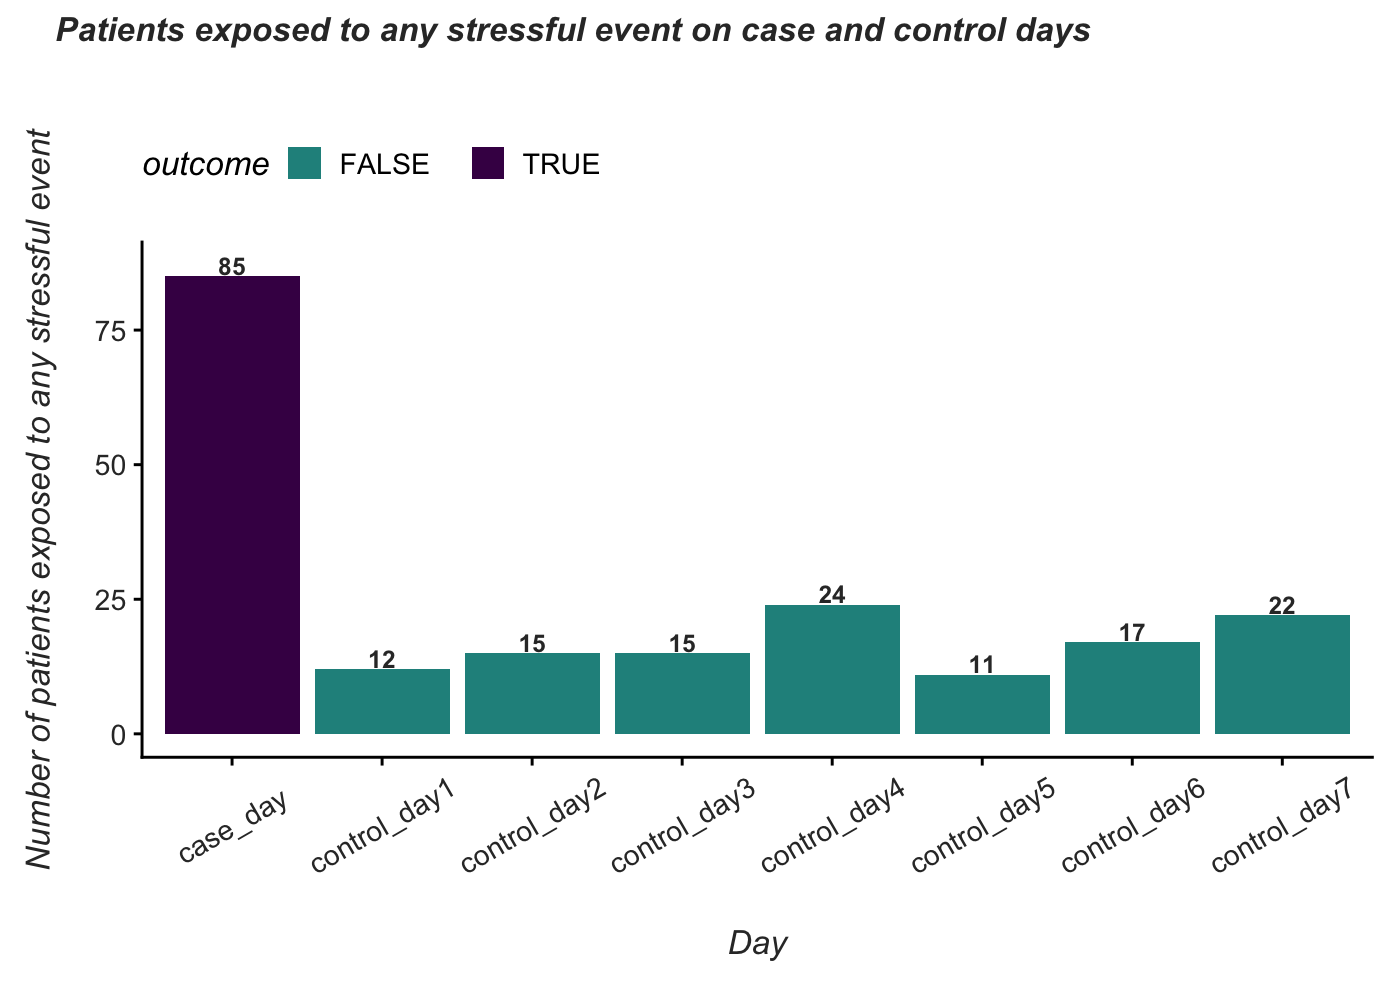

In [7]:
ggplot(data = exposures_per_day, aes(x = day)) +
  geom_bar(aes(weight = count, fill = outcome), show.legend = TRUE) +
  geom_text(aes(y = count, label = count, fontface ="bold"),
    nudge_y = 2,
    size = 3.1,
    hjust = "middle",
    color = "gray20") +
  labs(
    x = "Day",
    y = "Number of patients exposed to any stressful event",
    title = "Patients exposed to any stressful event on case and control days"
  ) +
  theme(axis.text.x = element_text(angle = 30, vjust = 0.5)) +
  scale_fill_manual(values = c("#21908CFF", "#440154FF"))

## Compare numbers of self-poisonings on exposed and unexposed days

Since we are going to compare the odds of self-poisoning on days with and without exposure several times, it is useful to create a function drawing this plot.

In the function below using grouping variable is optional.

The function takes the following arguments:

- `dtst` a data frame with variables outcome and exposure, should also contain grouping variable if it is provided within the function call
- `gv` optional grouping variable
- `gv_label_false` and `gv_label_true` are optional variables used when `gv` is provided to label its levels, default to "FALSE" and "TRUE" respectively.

The function:

1. Checks if `gv` was provided and groups `dtst` by `gv` (if provided), outcome and exposure
2. Creates a data frame for a plot, with the counts in each group. Since counts are often used in tables summarizing data from case-control and case-crossover studies, it also creates character variable `weight_string` to display patient counts on the bars (to my best knowledge displaying it nicely cannot be achieved without creating additional variable)
3. Draws the plot
4. If `gv` is provided it uses it for `facet_wrap`.

In [8]:
create_outcome_plot <- function(dtst, gv, gv_label_false = "FALSE", gv_label_true = "TRUE") {
  #group by grouping variable (when provided) and exposure and outcome
  if(!missing(gv)){
    gv <- enquo(gv)
    outcome_plot_data <- dtst %>%
    mutate(group = !!gv) %>%
    group_by(group, exposure, outcome)
    }else{
    outcome_plot_data <- dtst %>%
    group_by(exposure, outcome)
    }

  #data for the plot  
  outcome_plot_data <- outcome_plot_data %>%
  summarise(weight = n()) %>%
  mutate(weight_string = paste0("n = ", weight)) %>%
  arrange(desc(exposure), desc(outcome))

  #plot call
  outcome_plot <- ggplot(data = outcome_plot_data, aes(x = exposure, y = weight)) +
  geom_col(aes(fill = outcome), position = "fill", width = 0.8) +
  geom_text(aes(label = weight_string),
    position = position_fill(vjust = 0.5),
    size = 3,
    color = "gray90",
    fontface = "bold") +
  coord_flip() +
  scale_fill_manual(values = c("#21908CFF", "#440154FF"), labels = c("no self-poisoning", "self-poisoning")) +
  scale_x_discrete(labels = c("no", "yes")) +
  labs(
    y = "proportion of patients",
    x = "exposure to stressful life event",
    fill = element_blank())

  if(!missing(gv)){
    mk_lbls <- function(string){
      if_else(string == "TRUE", gv_label_true, gv_label_false)
    }
    outcome_plot <- outcome_plot +
    facet_wrap(~ group, labeller = labeller(group = mk_lbls), ncol = 1)
    }else{}

  return(outcome_plot)
}

After all this code it takes only a function call and a title to display the plot.

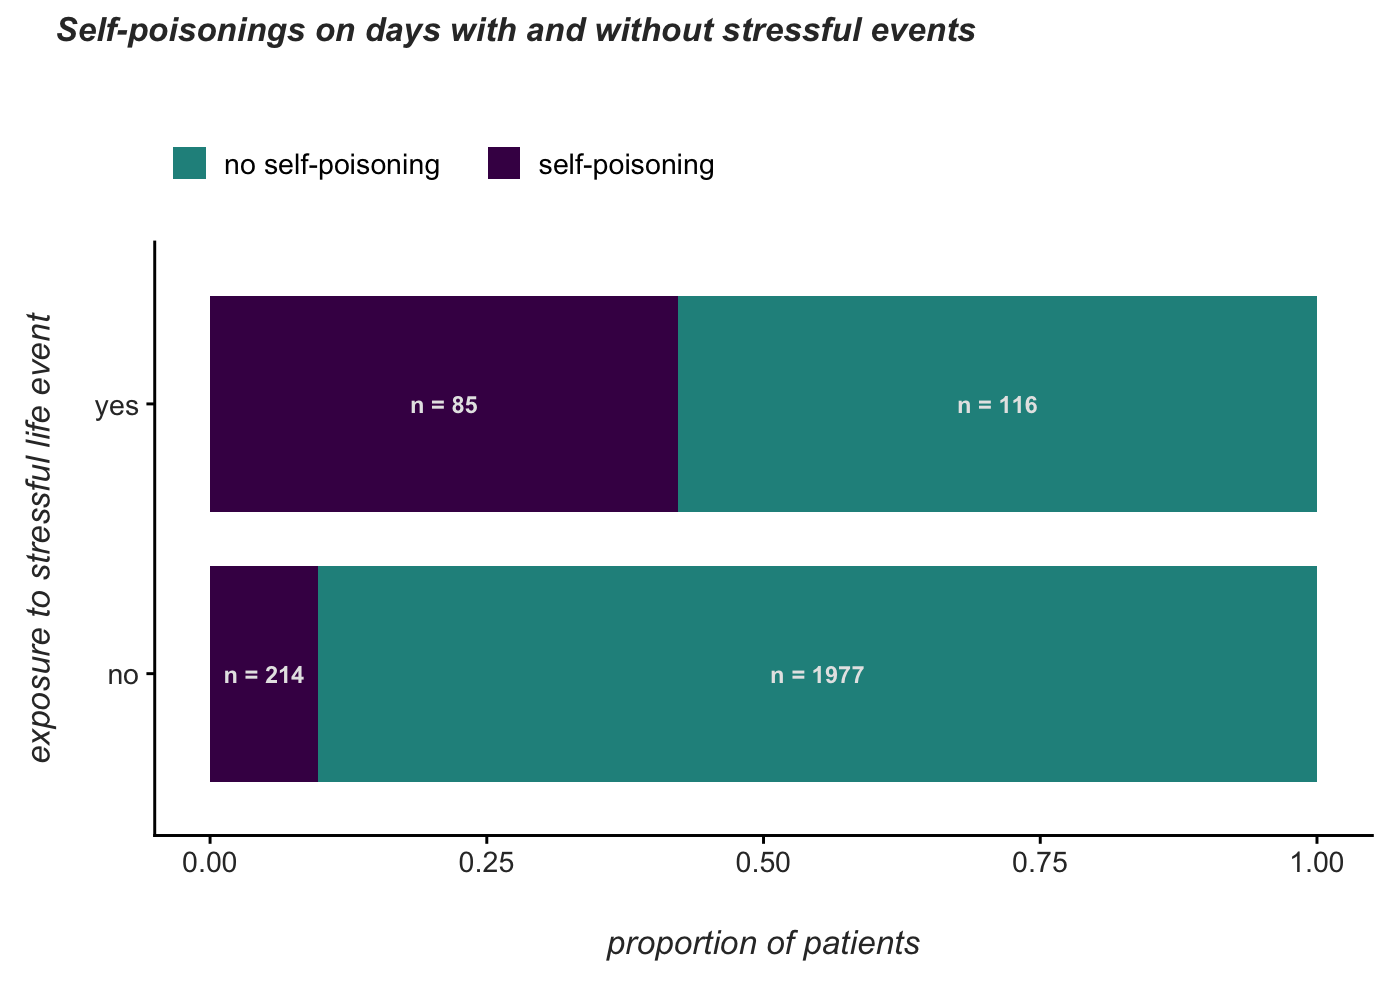

In [9]:
(outcome_plot_all <- create_outcome_plot(events_data) +
  labs(title = "Self-poisonings on days with and without stressful events"))

## Fitting a model

To fit conditional logistic regression model I use `survival::clogit`. Since the logic behind using conditional logistic regression is to take into account inter-patient variability, patient `id` is provided as strata argument. *Please note that these are not the same strata that are used in the stratified analysis below*.

In [10]:
#all data model
all <- clogit(outcome ~ exposure + strata(id),
  data = events_data)
summary(all)

Call:
coxph(formula = Surv(rep(1, 2392L), outcome) ~ exposure + strata(id), 
    data = events_data, method = "exact")

  n= 2392, number of events= 299 

               coef exp(coef) se(coef)     z Pr(>|z|)    
exposureTRUE 1.9148    6.7858   0.1646 11.63   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

             exp(coef) exp(-coef) lower .95 upper .95
exposureTRUE     6.786     0.1474     4.915     9.369

Concordance= 0.614  (se = 0.014 )
Likelihood ratio test= 125.7  on 1 df,   p=<2e-16
Wald test            = 135.4  on 1 df,   p=<2e-16
Score (logrank) test = 176.1  on 1 df,   p=<2e-16


OR is exp(coef), so in this case the odds of self-poisoning is 6.79 times higher after exposure to a stressful life event.

## Comparing raw data in groups

Now we can easily compare raw data in groups using plotting function created before. Since I want to display the plots on a grid, I don't need title, legend and x axis title and text on each plot. To get rid of them let's create a function `plots_for_grid`, which slightly modifies the result of `create_outcome_plot` (it takes plot as an argument).

In [11]:
plots_for_grid <- function(plot) {
  new_plot <- plot +
    theme(legend.position = "none",
          plot.margin = margin(l = 20, r = 10, t = 0, b = 0),
          axis.title.x = element_blank(),
          axis.text.x = element_blank()
         ) +
    labs(title = element_blank())
  return(new_plot)
}

Now we can create a plot for each grouping variable...

In [12]:
plot_women <- plots_for_grid(create_outcome_plot(events_data,
  women,
  gv_label_false = "men",
  gv_label_true = "women"))

plot_psychiatric_history <- plots_for_grid(create_outcome_plot(events_data,
  psychiatric_history,
  gv_label_false = "patients who didn't receive previous psychiatric treatment",
  gv_label_true = "patients who received previous psychiatric treatment"))

plot_depression <- plots_for_grid(create_outcome_plot(events_data,
  depression,
  gv_label_false = "patients not diagnosed with depression",
  gv_label_true = "patients diagnosed with depression"))

plot_attempts <- plots_for_grid(create_outcome_plot(events_data,
  attempts,
  gv_label_false = "patients who didn't make previous suicide attempts",
  gv_label_true = "patients who made previous suicide attempts"))

...and display it in a grid. Variable `legend` is extracted by `cowplot::get_legend` from outcome plot for total number of patients (group plots do not have legends). Title for the whole grid is created by `cowplot::draw_label`.

In [13]:
legend <- get_legend(outcome_plot_all)
title <- ggdraw() +
  draw_label(
    "Odds and number of self-poisonings in groups",
    fontface = 'bold',
    x = 0,
    hjust = 0,
    size = 12)

Title and legend are aligned in a grid along with plots. Bottom plot is modified to have x axis (other plots do not have it, so it can be displayed only once at the bottom). To preserve bars width in rel_heights parameter it takes some more space.

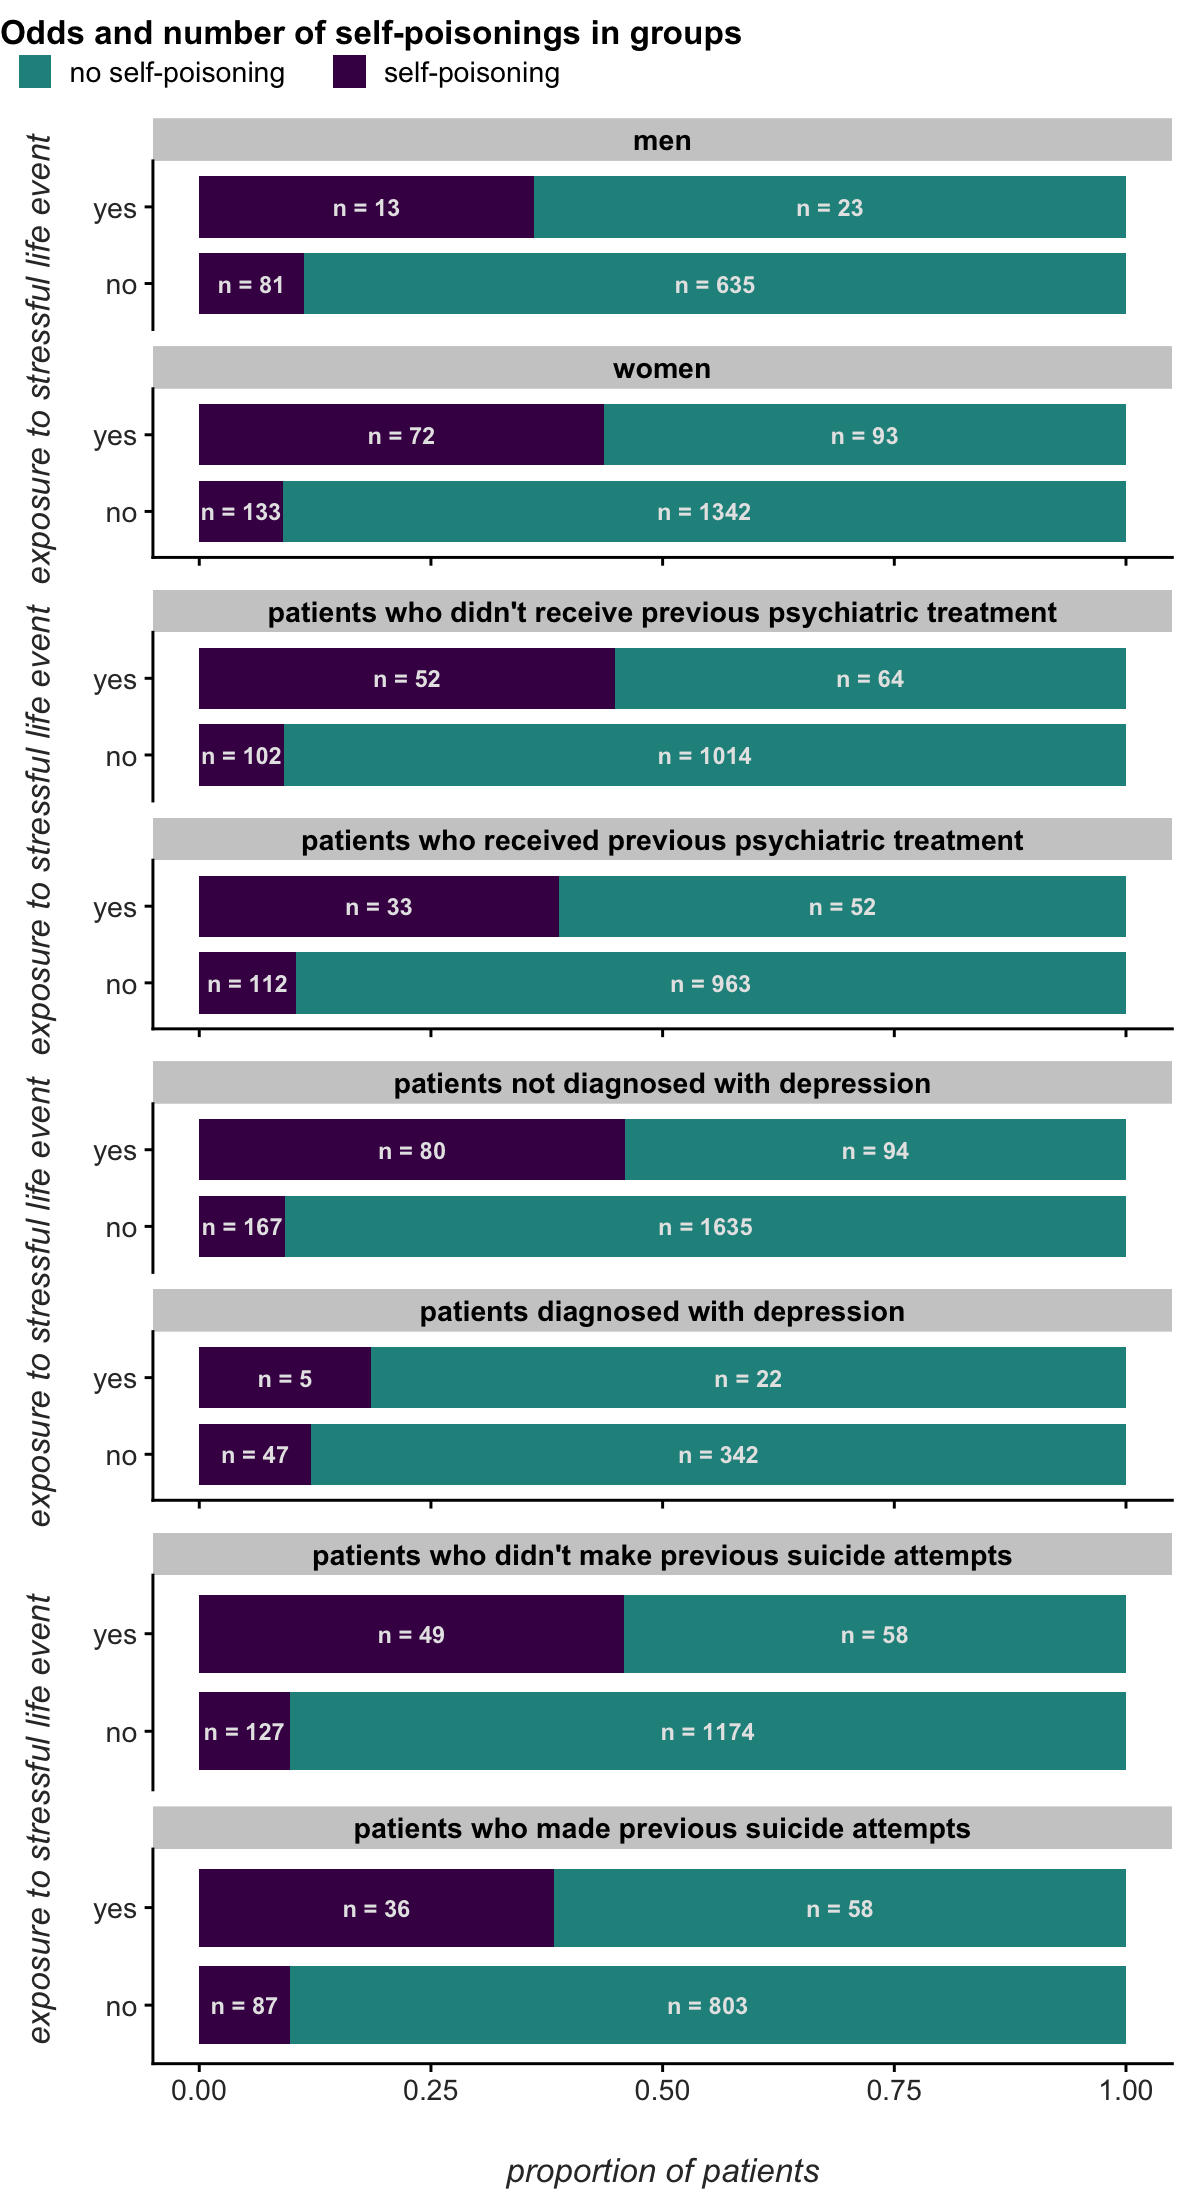

In [14]:
options(repr.plot.width = 6, repr.plot.height = 11)
plot_grid(title,
  legend,
  plot_women,
  plot_psychiatric_history,
  plot_depression,
  plot_attempts +
    theme(axis.text.x = element_text(),
      plot.margin = margin(l = 20, r = 10, t = 0, b = 20),
      axis.title.x = element_text()),
  ncol = 1,
  rel_heights = c(0.2, 0.1, 1.5, 1.5, 1.5, 2.2)
  )

## Stratified ORs

### Goal

The goal of stratified analysis presented here is to compare ORs and verify if they differ significantly between groups. To achieve this statistical significance of rate ratio (RR) is verified with conditional logistic regression with interaction between exposure and grouping variable. Grouping variable identifies different strata. Here we have e.g. women compared to man (`women == TRUE` vs `women == FALSE`) or patients diagnosed with depression compared to patients without this diagnosis (`depression == TRUE` vs `depression == FALSE`). *Please note, that this strata here should not be confused with strata in `survival::clogit` call used to run CLG!*

Since `survival::clogit` do not require adding both variables of the interaction term as separate terms, the call is: `outcome ~ exposure*grouping_variable + strata(id)`.

### Example

As an example, to compare ORs between sexes we have:

In [15]:
(interaction <- clogit(outcome ~ exposure*women + strata(id), data = events_data))

Call:
clogit(outcome ~ exposure * women + strata(id), data = events_data)

                         coef exp(coef) se(coef)     z        p
exposureTRUE           1.5721    4.8166   0.3869 4.063 4.84e-05
womenTRUE                  NA        NA   0.0000    NA       NA
exposureTRUE:womenTRUE 0.4191    1.5206   0.4278 0.980    0.327

Likelihood ratio test=126.6  on 2 df, p=< 2.2e-16
n= 2392, number of events= 299 

`exp(coef)` in the first row below the call is OR for self-poisoning after exposure **in the group for which grouping variable is `FALSE`**, in this example men. Second row has only NAs, because patients were their own controls, so the level of grouping variable was constant during all case and control times. `exp(coef)` in the third row is the coefficient of the interaction term and it translates to the rate ratio (RR) between `women == FALSE` and `women == TRUE` group. So we know, that the OR of self-poisoning after exposure to a stressful life event is 1.52 times higher among women than among men.

Just to check, OR among men:

In [16]:
(men <- clogit(outcome ~ exposure + strata(id),
    data = events_data %>% filter(!women)))

Call:
clogit(outcome ~ exposure + strata(id), data = events_data %>% 
    filter(!women))

               coef exp(coef) se(coef)     z        p
exposureTRUE 1.5721    4.8166   0.3869 4.063 4.84e-05

Likelihood ratio test=14.67  on 1 df, p=0.0001277
n= 752, number of events= 94 

OR among women:

In [17]:
(women <- clogit(outcome ~ exposure + strata(id),
    data = events_data %>% filter(women)))

Call:
clogit(outcome ~ exposure + strata(id), data = events_data %>% 
    filter(women))

               coef exp(coef) se(coef)     z      p
exposureTRUE 1.9912    7.3240   0.1825 10.91 <2e-16

Likelihood ratio test=112  on 1 df, p=< 2.2e-16
n= 1640, number of events= 205 

The code below extracts `exp(coef)` from the summary of the model `men` and `women`, then extracts RR from the model with interaction and does the algebra necessary to show that `exp(coef)` is indeed RR.

In [18]:
(m <- summary(men)$coefficients[2])
(w <- summary(women)$coefficients[2])
i <- summary(interaction)$coefficients[3, 2]
m * i

[1] 4.816593

[1] 7.324038

[1] 7.324038

In this example RR is not statistically significant, so the data do not let us assume that the effect of stressful life events on triggering self poisoning is indeed more pronounced among women.

### Function to extract ORs and RR from the models

The function below extracts ORs for both levels of the grouping variable along with their confidence intervals and RR along with its p value.

It takes dataset and grouping variable as its arguments (grouping variable name is passed as a string). The dataset should have outcome, exposure and id variables and grouping variable should have two levels encoded as `TRUE` and `FALSE`.

The function:

1. Fits models for `FALSE` and `TRUE` groups to get ORs in this groups
2. Fits the mode with interaction term
3. Creates data frame with OR for both levels of the grouping variable and RR
4. Adds info about RR significance and stars to the data frame

*Actually only one model with interaction term could be fitted, but since the dataset is not so big, all three models are fitted for function code clarity.*

In [19]:
ORs_in_groups <- function(dataset, grouping_var) {
  false_group <- clogit(outcome ~ exposure + strata(id),
    data = dataset %>% filter(!dataset[[grouping_var]]))
  true_group <- clogit(outcome ~ exposure + strata(id),
    data = dataset %>% filter(dataset[[grouping_var]]))

  full_model <- clogit(outcome ~ exposure*dataset[[grouping_var]] + strata(id),
  data = dataset)

  ORs <- data.frame(
    grouping_var = grouping_var,
    grouping_var_level = c(FALSE, TRUE),
    OR = c(
      summary(false_group)$conf.int[ , "exp(coef)"],
      summary(true_group)$conf.int[ , "exp(coef)"]
      ),
    OR_lower_95 = c(
      summary(false_group)$conf.int[ , "lower .95"],
      summary(true_group)$conf.int[ , "lower .95"]
      ),
    OR_upper_95 = c(
      summary(false_group)$conf.int[ , "upper .95"],
      summary(true_group)$conf.int[ , "upper .95"]
      ),
    RR = rep(summary(full_model)$coefficients[3, "exp(coef)"], 2),
    RR_p_value = rep(summary(full_model)$coefficients[3, "Pr(>|z|)"], 2)
   )

  ORs <- ORs %>%
  mutate (RR_sig = case_when(
    RR_p_value < 0.1 & RR_p_value >= 0.05 ~ paste0("ns, p = ", round(RR_p_value, digits = 3)),
    RR_p_value < 0.05 & RR_p_value >= 0.01 ~ "p < 0.05",
    RR_p_value < 0.01 & RR_p_value >= 0.001 ~ "p < 0.01",
    RR_p_value < 0.001 ~ "p < 0.001",
    TRUE ~ "ns"
    )) %>%
  mutate(stars = case_when(
    RR_p_value < 0.1 & RR_p_value >= 0.05 ~ "+",
    RR_p_value < 0.05 & RR_p_value >= 0.01 ~ "*",
    RR_p_value < 0.01 & RR_p_value >= 0.001 ~ "**",
    RR_p_value < 0.001 ~ "***",
    TRUE ~ ""))

  return(ORs)
}

Results for each of the for grouping variables can be easily combined into one data frame.

In [20]:
women_ORs <- ORs_in_groups(events_data, "women")
psychiatric_history_ORs <- ORs_in_groups(events_data, "psychiatric_history")
depression_ORs <- ORs_in_groups(events_data, "depression")
attempts_ORs <- ORs_in_groups(events_data, "attempts")
(stratified_ORs <- rbind(women_ORs, psychiatric_history_ORs, depression_ORs, attempts_ORs))

grouping_var,grouping_var_level,OR,OR_lower_95,OR_upper_95,RR,RR_p_value,RR_sig,stars
<fct>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
women,FALSE,4.816593,2.2564103,10.281626,1.5205849,0.327242216,ns,
women,TRUE,7.324038,5.1213241,10.474154,1.5205849,0.327242216,ns,
psychiatric_history,FALSE,7.519714,4.9434510,11.438589,0.7763679,0.449989466,ns,
psychiatric_history,TRUE,5.838065,3.5221445,9.676776,0.7763679,0.449989466,ns,
depression,FALSE,8.420960,5.9133058,11.992034,0.1961755,0.003015372,p < 0.01,**
depression,TRUE,1.651986,0.5977784,4.565333,0.1961755,0.003015372,p < 0.01,**
attempts,FALSE,7.362849,4.8208571,11.245208,0.8228825,0.558445511,ns,
attempts,TRUE,6.058759,3.6858800,9.959239,0.8228825,0.558445511,ns,


### Plotting ORs

The data frame with ORs can be easily plotted. The adjustments below are optional and provide nice labels for grouping variables with information about RR and its significance level.

In [21]:
stratified_ORs$grouping_var <- recode(stratified_ORs$grouping_var,
  "women" = "women",
  "psychiatric_history" = "psychiatric treatment history",
  "depression" = "depression diagnosis",
  "attempts" = "previous suicide attempts")

stratified_ORs <- stratified_ORs %>%
mutate(grouping_var_rr = paste0(grouping_var,
  ": RR = ",
  round(RR, digits = 2),
  stars))

The data frame is plotted with `ggplot::geom_point()`, where points represent ORs and `ggplot:error_bar()`, where bars represent confidence intervals.

As you can see, overlapping error bars translate to non-significant RR.

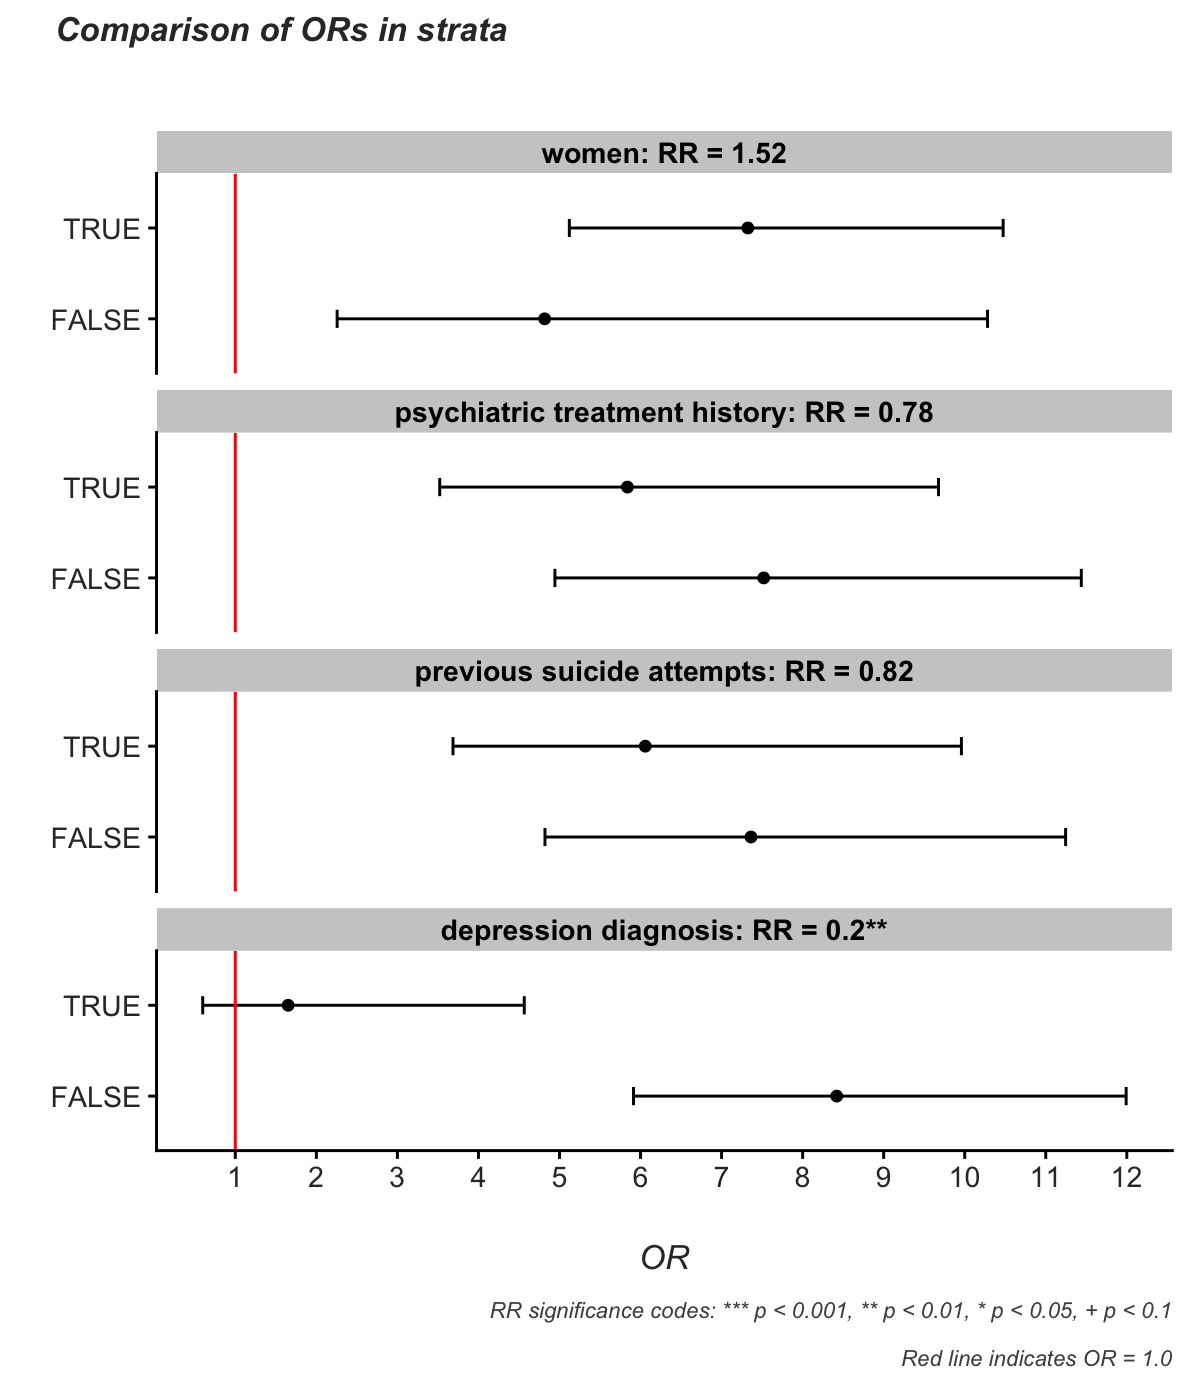

In [22]:
options(repr.plot.width = 6, repr.plot.height = 7)

ggplot(data = stratified_ORs, aes(x = OR, y = grouping_var_level)) +
  geom_point() +
  geom_errorbar(aes(xmin = OR_lower_95, xmax = OR_upper_95), width = 0.2) +
  geom_vline(xintercept = 1, color = "red") +
  scale_x_continuous(breaks = seq(0, 12.5, by = 1)) +
  facet_wrap(~ grouping_var_rr, ncol = 1, as.table = FALSE) +
  theme(axis.title.y = element_blank()) +
  labs(title = "Comparison of ORs in strata",
    caption = "RR significance codes: *** p < 0.001, ** p < 0.01, * p < 0.05, + p < 0.1\n
    Red line indicates OR = 1.0")

I hope you enjoyed stratified ORs! :)